In [1]:
# Copyright (c) Microsoft Corporation. All rights reserved.
# Licensed under the MIT License.

# Data Preprocessing Examples
This notebook provides examples of preprocessing imagery data, specifically mosaicking, tiling, and getting the footprint of a raster.

In [2]:
import os
from dotenv import load_dotenv
import numpy as np
import geopandas as gpd
import shapely.geometry
import rasterio
import rasterio.features
import rasterio.warp
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Get values of environment variables
load_dotenv(dotenv_path='../config/local/.env')
RAW_DATA_ROOT = os.environ['RAW_DATA_ROOT'] # absolute path to folder where the sample data Azure blob is downloaded
PROJECT_ROOT = os.environ['PROJECT_ROOT'] # absolute path to the root of this repo

## Mosaicking with `create_mosaic_cog.py`

Mosaicking is an important step in preprocessing aerial imagery, where multiple images are combined into one seamless image, or mosaic. This is particularly useful when dealing with large spatial areas covered by multiple images, as is the case for Kakuma and Kalobeyei. Here, we mosaic imagery data for the Kakuma_15 area included in the example dataset.

To begin, let's examine the initial state of our imagery in the Kakuma_15 area. We have two TIFF files for this area: Kakuma_15A_Flight_1-4.tif and Kakuma_15B_Flight_1-2.tif. These files are listed in `create_mosaic_cog-kakuma_15.txt`. A footprint plot of these files reveals their spatial overlap:

100%|██████████| 2/2 [04:47<00:00, 143.54s/it]


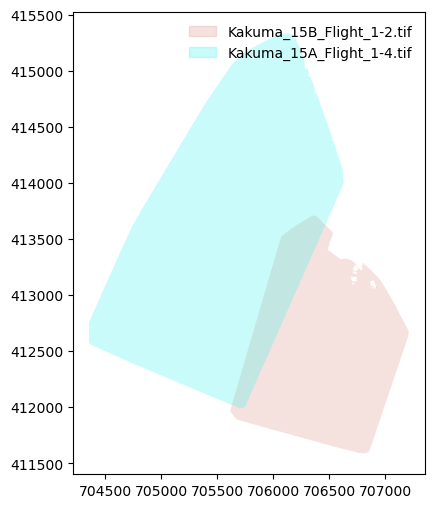

In [3]:
# Get raster files in ../config/data_preprocessing/create_mosaic_cog/create_mosaic_cog-kakuma_15.txt
imagery_files = [
    os.path.join(RAW_DATA_ROOT, f.strip())
    for f in open('../config/examples/data_preprocessing/create_mosaic_cog/create_mosaic_cog-kakuma_15.txt').readlines()
]

# Generate random colors, one for each file
colors = np.random.rand(len(imagery_files), 3)

# Create a figure
fig, ax = plt.subplots(figsize=(6, 6))
legend_patches = []

# Loop through each file
for i, file in enumerate(tqdm(imagery_files)):
    with rasterio.open(file) as src:
        mask = src.read_masks(1) # Read the raster's valid data mask as a ndarray
        mask = rasterio.features.sieve(mask, 1000) # Sieve out small objects

        # Get shapes of valid data areas from the mask
        shapes = [g for g,v in rasterio.features.shapes(mask, transform=src.transform) if v > 0]

        # Plot shapes
        gdf = gpd.GeoDataFrame({'geometry': [shapely.geometry.shape(shape) for shape in shapes]})
        gdf.crs = src.crs
        gdf.plot(ax=ax, color=colors[i], alpha=0.3, linewidth=2, label=os.path.basename(file))

        # Create a patch for the legend
        legend_patches.append(Patch(color=colors[i], alpha=0.3, label=os.path.basename(file)))

ax.legend(handles=legend_patches, frameon=False)
plt.show()


The image above displays the footprints of the individual TIFF files for the Kakuma_15 area. The intersecting areas indicate regions with imagery from multiple files. In these overlapping regions, the image data incorporated into the final mosaic is determined by the order of the files in the input list--the later an image appears in the list, the higher its priority when resolving overlaps. This means that in these intersecting regions, the data from the image listed later in the input list will be used in the final mosaic.

The following command generates a mosaicked COG for Kakuma_15:
```bash
set -a
source ./config/local/.env
set +a

cd ./scripts/data_preprocessing
python create_mosaic_cog.py -i ../../config/examples/data_preprocessing/create_mosaic_cog/create_mosaic_cog-kakuma_15.txt -o ../../data/interim/example_mosaic_cogs/kakuma_15.tif -r $RAW_DATA_ROOT -v
```
You might want to combine all available TIFF files into a single mosaic, or process a few at a time. In this project, we ran `create_mosaic_cog.py` 4 times to create separate mosaics of imagery in the regions Kakuma_15, Kakuma_17, Kalobeyei_01 and Kalobeyei_03, the main areas where we had both imagery and annotations.

Upon completion of the mosaicking process, the resulting COG for the Kakuma_15 area can be visualized to see how the individual images have been combined in the mosaic.

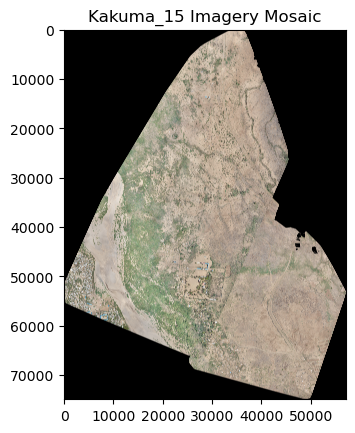

In [4]:
# Open the mosaicked COG for Kakuma_15
with rasterio.open('../data/interim/example_mosaic_cogs/kakuma_15.tif') as src:
    # Read the raster data
    data = src.read()
    # Exclude band 4 (alpha) from the plot
    data = data[0:3,:,:]

    # Plot the raster data
    plt.imshow(data.transpose(1, 2, 0))
    plt.title('Kakuma_15 Imagery Mosaic')
    plt.show()


## Tiling with `tile_raster.py`

Tiling in geospatial data analysis involves dividing a large dataset into smaller, non-overlapping 'tiles'. This can help with efficient data management and processing, and allows us to create distinct training, validation, and testing sets for developing machine learning models, promoting model generalization.

Let's divide the Kakuma_15 mosaic into 500m x 500m tiles.
```bash
python tile_raster.py -c ../../config/examples/data_preprocessing/tile_raster/tile_raster-kakuma_15.yml -r $PROJECT_ROOT
```
This script saves an image of the grid used to tile the Kakuma_15 mosaic in `$PROJECT_ROOT/reports/figures/example_tiled_datasets/tile_size_500/kakuma_15.png`. Let's view the saved image:

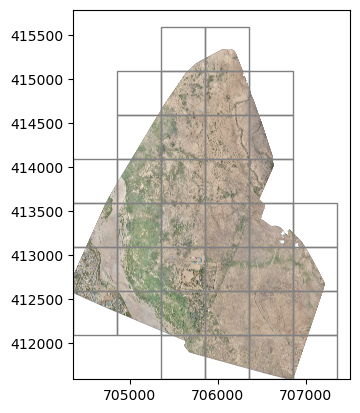

In [5]:
from IPython.display import Image
Image('../reports/figures/example_tiled_datasets/tile_size_500/kakuma_15.png')

There are 37 tiles containing aerial imagery, each of which has been saved to a separate file like `$PROJECT_ROOT/data/processed/example_tiled_datasets/tile_size_500/images/kakuma_15_tile_1.tif`. We ran `tile_raster.py` 4 times to tile each of the mosaics we created for Kakuma_15, Kakuma_17, Kalobeyei_01, and Kalobeyei_03.

## Getting Raster Imagery Extent with `get_raster_footprint.py`
Having a shapefile that delineates the extent of your raster imagery can be incredibly handy. Here's how we can generate the extent or footprint for Kakuma_15:
```bash
python get_raster_footprint.py -f ../../data/interim/example_mosaic_cogs/kakuma_15.tif -o ../../data/interim/example_mosaic_cog_footprints/kakuma_15.shp
```

Visualizing the extent of our imagery becomes much easier with these shapefiles:

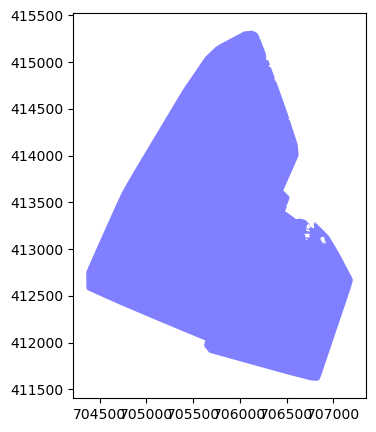

In [6]:
fig, ax = plt.subplots(figsize=(5, 5))
extent = gpd.read_file('../data/interim/example_mosaic_cog_footprints/kakuma_15.shp')
extent.plot(ax=ax, color='blue', alpha=0.5, edgecolor='none', linewidth=2)
plt.show()